In [39]:
!pip install mplcyberpunk

In [40]:
import polars as pl
import polars.selectors as cs
import numpy as np

from keras import layers, Model, optimizers, losses, metrics, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import mplcyberpunk
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('cyberpunk')

In [41]:
from google.colab import drive
drive.mount('/content/drive')

# Load network_traffic_data.csv from Google Drive
df_drive = pl.read_csv('/content/drive/MyDrive/network_traffic_data.csv')
print("First 5 rows of df_drive (from Google Drive):")
display(df_drive.head())

# Load network_traffic_formatted1.csv from Google Drive
df_local = pl.read_csv('/content/drive/MyDrive/network_traffic_formatted1.csv')
print("\nFirst 5 rows of df_local (from Google Drive):")
display(df_local.head())

# Assign df_drive to df for subsequent operations
df = df_drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
First 5 rows of df_drive (from Google Drive):


Source_IP,Destination_Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type,Timestamp
str,i64,str,str,i64,str,str,i64,str,str
"""159.222.245.19""",30479,"""TELNET""","""UDP""",2115,"""Java/11.0.10""","""Success""",1,"""XSS""","""2025-11-13 04:49:00"""
"""57.188.195.92""",25,"""SMTP""","""UDP""",1073,"""Apache-HttpClient/4.5.13""","""Success""",0,"""Normal""","""2025-11-05 10:03:04"""
"""61.172.166.43""",8443,"""HTTPS""","""UDP""",2929,"""Apache-HttpClient/4.5.13""","""Failure""",1,"""XSS""","""2025-11-11 09:47:39"""
"""92.177.138.185""",110,"""SSH""","""TCP""",1728,"""curl/7.68.0""","""Failure""",1,"""SQLInjection""","""2025-11-21 06:13:18"""
"""83.246.120.214""",38310,"""HTTP""","""TCP""",1962,"""curl/7.68.0""","""Success""",1,"""DDoS""","""2025-11-04 23:48:24"""



First 5 rows of df_local (from Google Drive):


Timestamp,Source_IP,Destination_Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
str,str,str,str,str,i64,str,str,i64,str
"""01-06-2025 00:11""","""192.168.198.203""","""39.63.105.165:110""","""SMTP""","""TCP""",2419,"""python-requests/2.25""","""Success""",1,"""PortScan"""
"""01-06-2025 00:12""","""192.168.11.230""","""102.112.30.106:40747""","""DNS""","""ICMP""",2924,"""Mozilla/5.0""","""Failure""",1,"""BotAttack"""
"""01-06-2025 00:13""","""192.168.59.237""","""192.168.207.159:110""","""FTP""","""UDP""",1170,"""curl/7.68.0""","""Success""",1,"""SQLInjection"""
"""01-06-2025 00:15""","""192.168.112.76""","""159.89.211.238:21""","""SMTP""","""UDP""",1021,"""Apache-HttpClient/4.5""","""Success""",1,"""BruteForce"""
"""01-06-2025 00:21""","""192.168.112.65""","""24.5.167.38:445""","""FTP""","""ICMP""",2093,"""Go-http-client/1.1""","""Success""",1,"""BotAttack"""


In [42]:
str_cols = df.select(cs.string())

def ordinal_encode(series : pl.Series) -> dict:
    unique_values = [*series.unique()]
    unique_dict = dict()

    for i in range(len(unique_values)):
        unique_dict[unique_values[i]] = i

    return unique_dict

for col in str_cols:
    if col.n_unique() > 10:
        continue
    else:
        mapping = ordinal_encode(col)
        str_cols = str_cols.with_columns(pl.col(col.name).replace(mapping).cast(pl.Float64))

df = df.with_columns(str_cols).cast({cs.numeric() : pl.Float64})
df = df.drop(cs.string())

In [43]:
scaler = MinMaxScaler()

x = df
y = x.drop_in_place('Intrusion')
scaled_x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.10, random_state=42)

In [44]:
models = {
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier' : GradientBoostingClassifier(),
    'LogisticRegression' : LogisticRegression(),
    'LinearSVC' : LinearSVC(),
    'KNeighborsClassifier' : KNeighborsClassifier()
}

parameters = {
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'GradientBoostingClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'loss': ['log_loss', 'exponential']
    },
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2']
    },
    'LinearSVC': {
        'C': [0.01, 0.1, 1, 10, 100],
        'loss': ['hinge', 'squared_hinge'],
        'penalty': ['l1', 'l2'],
        'dual': [True, False]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        'p': [1, 2]
    }
}

In [45]:
preds = {}
accuracies = {}

In [46]:
for model in models.keys():
    current_model = GridSearchCV(
        models[model],
        parameters[model],
        cv=2, n_jobs=-1, verbose=1
    )
    current_model.fit(x_train, y_train)
    current_pred = current_model.predict(x_test)
    preds[model] = current_pred


Fitting 2 folds for each of 162 candidates, totalling 324 fits
Fitting 2 folds for each of 108 candidates, totalling 216 fits
Fitting 2 folds for each of 24 candidates, totalling 48 fits
Fitting 2 folds for each of 40 candidates, totalling 80 fits
Fitting 2 folds for each of 32 candidates, totalling 64 fits


In [47]:
inputs = layers.Input((x_train.shape[-1],))
x = layers.Dense(units=32, activation='relu')(inputs)
x = layers.Dense(units=64, activation='relu')(x)
x = layers.Dense(units=128, activation='relu')(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)

keras_model = Model(inputs, outputs)
keras_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817 (42.25 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
keras_model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=[metrics.BinaryAccuracy()]
)

early_stopping = callbacks.EarlyStopping(
    patience=10
)

plateau = callbacks.ReduceLROnPlateau(
    patience=10
)

history = keras_model.fit(
    x=x_train,
    y=y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, plateau]
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - binary_accuracy: 0.7629 - loss: 0.5569 - val_binary_accuracy: 0.8194 - val_loss: 0.4530 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8528 - loss: 0.3927 - val_binary_accuracy: 0.8194 - val_loss: 0.4123 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8737 - loss: 0.3284 - val_binary_accuracy: 0.8194 - val_loss: 0.3947 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8568 - loss: 0.3596 - val_binary_accuracy: 0.8194 - val_loss: 0.4058 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8596 - loss: 0.3459 - val_binary_accuracy: 0.8194 - val_loss: 0.3862 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8703 - loss: 0.3146 - val_binary_accuracy: 0.8194 - val_loss: 0.3586 - learning_rate: 0.0010
Epoch 7/10
45/4

In [49]:
print(accuracies)

{}


In [50]:
keras_pred = keras_model.predict(x_test)
preds['Keras'] = np.array((keras_pred > 0.5), np.float64).squeeze()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


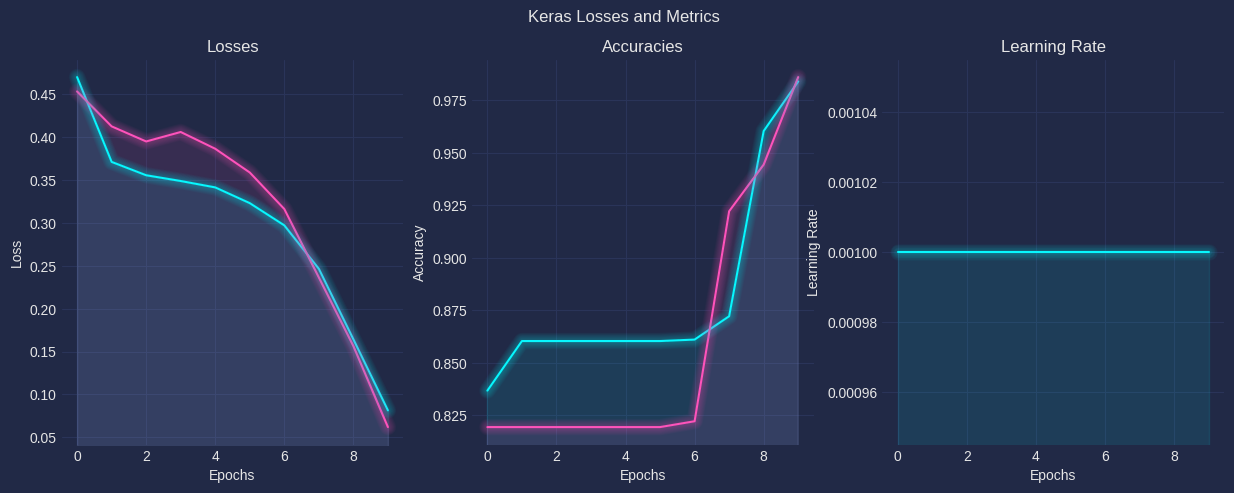

In [51]:
keras_history = history.history
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Keras Losses and Metrics')

ax[0].plot(keras_history['loss'])
ax[0].plot(keras_history['val_loss'])
ax[0].set_title('Losses')
ax[0].set_ylabel('Loss')

ax[1].plot(keras_history['binary_accuracy'])
ax[1].plot(keras_history['val_binary_accuracy'])
ax[1].set_title('Accuracies')
ax[1].set_ylabel('Accuracy')

ax[2].plot(keras_history['learning_rate'])
ax[2].set_title('Learning Rate')
ax[2].set_ylabel('Learning Rate')

for i in range(3):
    ax[i].set_xlabel('Epochs')
    mplcyberpunk.make_lines_glow(ax=ax[i])
    mplcyberpunk.add_underglow(ax=ax[i])

In [52]:
target_names = ['Normal', 'Attack']

for model in preds:
    current_pred = preds[model]
    cr = classification_report(y_test, current_pred, target_names=target_names)
    accuracies[model] = accuracy_score(y_test, current_pred)
    print(f'Classification Report for {model}\n {cr}')

Classification Report for RandomForestClassifier
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        48
      Attack       1.00      1.00      1.00       152

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Classification Report for GradientBoostingClassifier
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        48
      Attack       1.00      1.00      1.00       152

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Classification Report for LogisticRegression
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        48
      Attack       0.76      1.00      0.86       152

    accuracy                    

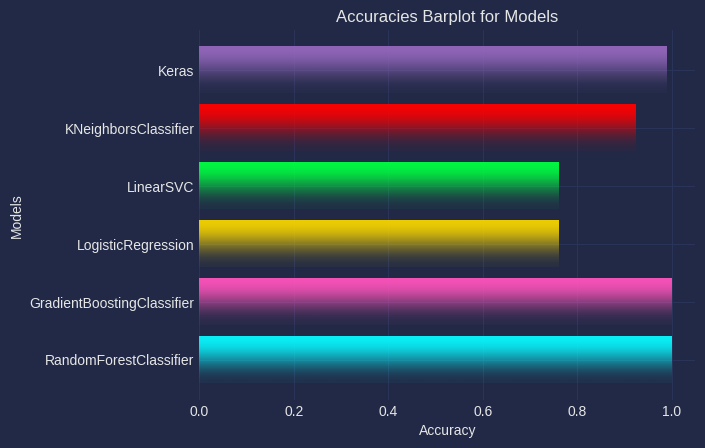

In [53]:
colors = ["C0", "C1", "C2", "C3", "C4", "C5"]

plt.title('Accuracies Barplot for Models')
plt.xlabel('Accuracy')
plt.ylabel('Models')
bars = plt.barh(list(accuracies.keys()), list(accuracies.values()), color=colors)
mplcyberpunk.add_bar_gradient(bars)

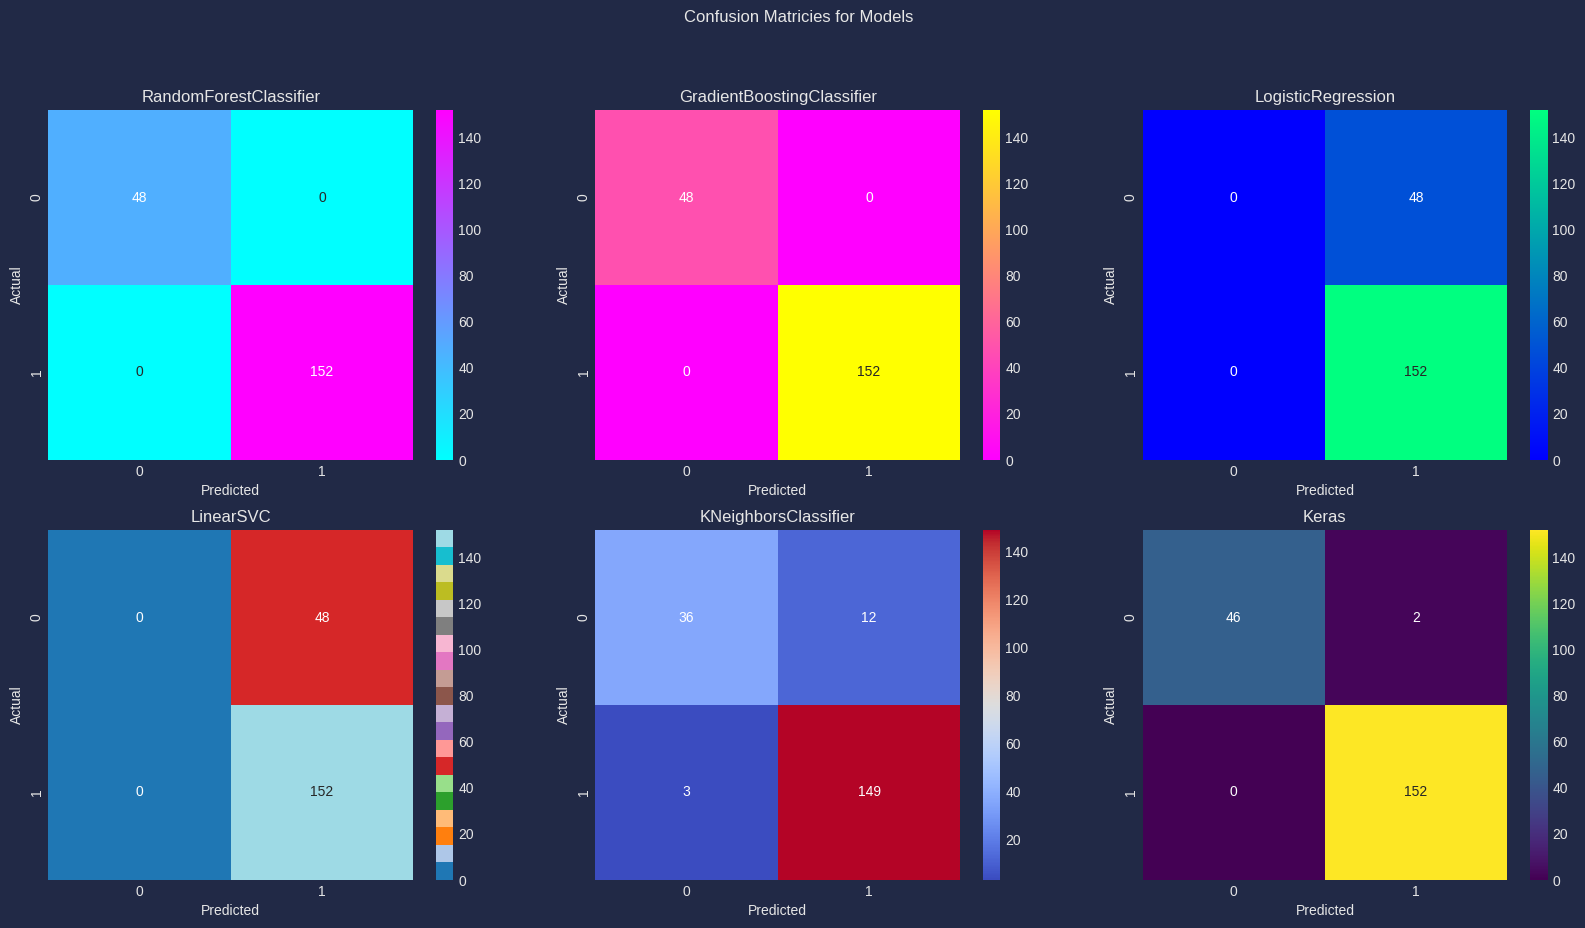

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.suptitle("Confusion Matricies for Models")
cmaps = ['cool', 'spring', 'winter', 'tab20', 'coolwarm', 'viridis']

for idx, col in enumerate(preds):
    axes = ax[idx // 3, idx % 3]
    axes.set_title(col)
    cm = confusion_matrix(y_test, preds[col])
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmaps[idx], ax=axes)
    axes.set_ylabel('Actual')
    axes.set_xlabel('Predicted')

In [57]:
import pickle

# Save the Keras model to a .pkl file
with open('keras_model.pkl', 'wb') as file:
    pickle.dump(keras_model, file)

print("Keras model saved successfully as 'keras_model.pkl'")

Keras model saved successfully as 'keras_model.pkl'
